In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import models, layers, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

In [2]:
%load_ext tensorboard
%matplotlib inline

In [ ]:
# only run on colab
from google.colab import drive
drive.mount('/content/drive')

In [3]:
train_data = np.load('./data/train.npz') if 'Eric' in os.uname().nodename else np.load('/content/drive/MyDrive/Colab Notebooks/data/train.npz')
#test_data = np.load('./data/public_test.npz') if 'Eric' in os.uname().nodename else np.load('/content/drive/MyDrive/Colab Notebooks/data/public_test.npz')

In [4]:
# separate bands and labels into individual data structures to improve performance
x_train = train_data['bands']
y_train = train_data['lulc']

# add class labels manually
classes = np.array(['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Tundra', 'Artificial Surface', 'Bareland', 'Snow and Ice'])

In [5]:
n_patches = x_train.shape[0]
n_months = x_train.shape[1]
n_classes = len(classes)
n_channels = x_train.shape[4]
f'patches: {x_train.shape}, labels: {y_train.shape}, classes: {classes.shape}'

'patches: (10000, 12, 33, 33, 6), labels: (10000,), classes: (11,)'

In [6]:
x_train_flattened = x_train.reshape((120000, 33, 33, 6))
y_train_flattened = np.array(list(map(lambda x: np.repeat(x, n_months), y_train))).reshape((120000))

In [7]:
np.histogram(y_train, bins=list(range(len(classes) + 1)))

(array([1308,  238, 5796, 1125,  770,   58,    0,    0,  217,  488,    0]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))

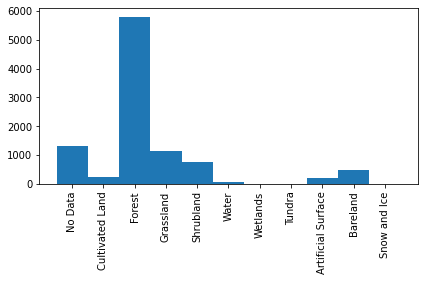

In [8]:
plt.hist(y_train, bins=list(range(len(classes) + 1)))
plt.xticks(ticks=list(map(lambda x: x+0.5, list(range(len(classes))))), labels=classes, rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# draw random patches
n_samples = 2
samples = np.random.randint(n_patches, size=n_samples)
# plot random samples from the training set
f, axes = plt.subplots(n_samples, n_months, figsize=(33,33))
for idx, sample in enumerate(samples):
    for month in range(n_months):
        axes[idx][month].imshow(x_train[sample][month][:, :, (2, 1, 0)])
        axes[idx][month].set_title(f'{classes[y_train[sample]]} - {month}')
f.tight_layout()
plt.tight_layout()
plt.show()

In [ ]:
# plot the test set
#f, axes = plt.subplots(1, n_months, figsize=(500,500))

#for month in range(n_months):
    #axes[month].imshow(test_bands[month][:, :, (2, 1, 0)])

In [ ]:
#idx_no_data = np.argwhere(y_train == 3).flatten()[:20]
# plot images labelled with no data
#f, axes = plt.subplots(len(idx_no_data), n_months, figsize=(33,33))
#for idx, patch in enumerate(idx_no_data):
#    for month in range(n_months):
#        axes[idx][month].imshow(x_train[patch][month][:, :, (2, 1, 0)])
#        axes[idx][month].set_title(f'p: {patch} - l: {classes[y_train[patch]]} - m: {month}')
#f.tight_layout()
#plt.tight_layout()
#plt.show()

Try different models

In [ ]:
# This model is similar to the VGGNets

model = models.Sequential()

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation=None, input_shape=(33,33,6)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU()) 
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.ReLU()) 
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.ReLU()) 
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.ReLU()) 
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.ReLU()) 
model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dropout(0.4))
model.add(layers.Dense(units=12, activation = 'softmax'))
model.summary()

In [ ]:
model = models.Sequential()

#model.add(layers.InputLayer(input_shape=(33, 33, 6)))
model.add(layers.Conv3D(filters=64, kernel_size=(1, 3, 3), padding='same', input_shape=(12, 33, 33, 6)))
model.add(layers.ReLU()) 
model.add(layers.GlobalAveragePooling3D())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(units=12, activation = 'softmax'))

model.summary()

In [ ]:
model = models.Sequential()
model.add(layers.Conv3D(32, (1, 3, 3), activation='relu', input_shape=(12, 33, 33, 6)))
model.add(layers.MaxPooling3D((1, 2, 2)))
model.add(layers.Conv3D(64, (1, 3, 3), activation='relu'))
model.add(layers.MaxPooling3D((3, 3, 3)))
model.add(layers.Conv3D(64, (1, 3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(12, activation='softmax'))
model.summary()

Current model

In [9]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(33, 33, 6)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(12, activation='softmax'))
model.summary()

2021-07-08 17:11:34.552793: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 31, 32)        1760      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
____________________________________________

In [10]:
# We use the Categorical Crossentropy (Classification Task) as Loss-Function and Adam as the optimizer
model.build()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

2021-07-08 17:11:35.259177: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-08 17:11:35.259363: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-07-08 17:11:35.283920: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


In [11]:
history = model.fit(x=x_train_flattened, y=y_train_flattened, epochs=1, callbacks=[tensorboard_callback], validation_split=0.2)

2021-07-08 17:11:35.692044: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
   3/3000 [..............................] - ETA: 5:26 - loss: 2.3406 - accuracy: 0.40622021-07-08 17:11:39.693598: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-08 17:11:39.693756: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-07-08 17:11:39.774338: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-07-08 17:11:39.776841: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-07-08 17:11:39.795080: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20210708-171135/train/plugins/profile/2021_07_08_17_11_39
2021-07-08 17:11:39.799277: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.g

In [ ]:
%tensorboard --logdir logs/fit --port=8008

In [12]:
preds = model.predict(x_train_flattened)
np.histogram(preds.argmax(1), bins=list(range(len(classes) + 1)))

(array([     0,      0, 105742,   6526,     58,      0,      0,      0,
             0,   7674,      0]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))

In [ ]:
# plot prediction histogram
plt.hist(preds.argmax(1), bins=list(range(len(classes) + 1)))
plt.xticks(ticks=list(map(lambda x: x+0.5, list(range(len(classes))))), labels=classes, rotation=90)
plt.tight_layout()
plt.show()

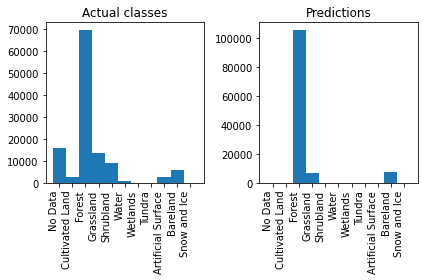

In [13]:
# plot predictions versus actual labels histogram
f, axes = plt.subplots(1, 2)

axes[0].hist(y_train_flattened, bins=list(range(len(classes) + 1)))
axes[0].set_xticks(ticks=list(map(lambda x: x+0.5, list(range(len(classes))))))
axes[0].set_xticklabels(classes, rotation=90, ha='right')
axes[0].set_title('Actual classes')

axes[1].hist(preds.argmax(1), bins=list(range(len(classes) + 1)))
axes[1].set_xticks(ticks=list(map(lambda x: x+0.5, list(range(len(classes))))))
axes[1].set_xticklabels(classes, rotation=90, ha='right')
axes[1].set_title('Predictions')

plt.tight_layout()
plt.show()

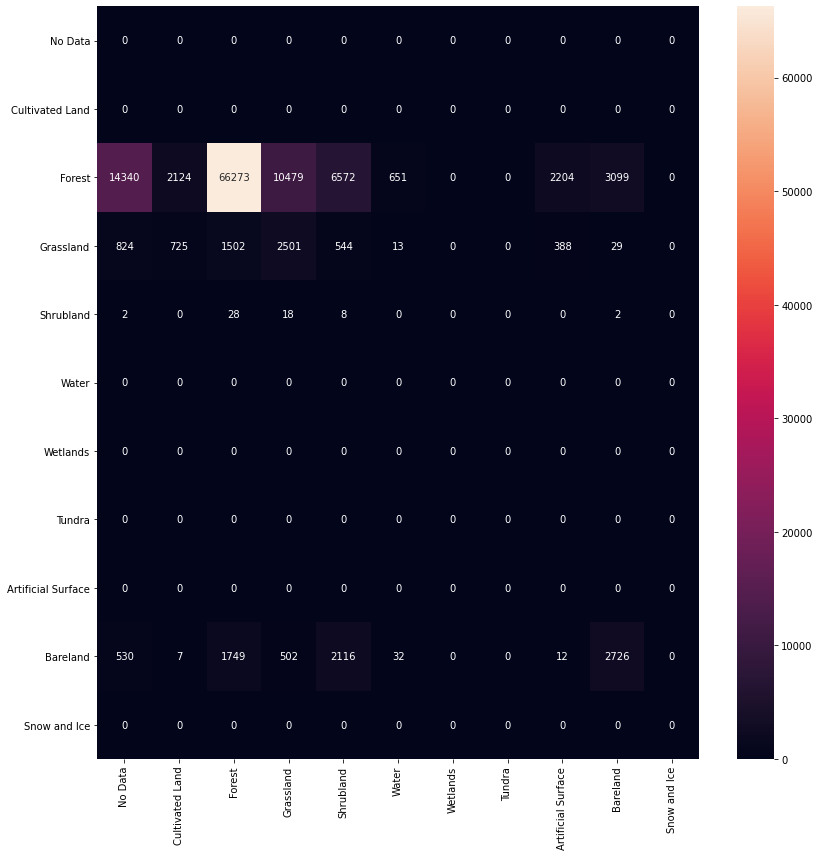

In [14]:
df_cm = pd.DataFrame(confusion_matrix(classes[preds.argmax(1)], classes[y_train_flattened], labels=classes), index=classes, columns=classes)
plt.figure(figsize = (12,12))
heatmap(df_cm, annot=True, fmt='d')
plt.tight_layout()
plt.show()